# FOUR

### Data Augmentation

In order to teach the model to be more robust when looking at new data, programmatically increase the size and variance in the dataset. This is known as [*data augmentation*](https://link.springer.com/article/10.1186/s40537-019-0197-0), a useful technique for many deep learning applications.

The increase in size gives the model more images to learn from while training. The increase in variance helps the model ignore unimportant features and select only the features that are truly important in classification, allowing it to generalize better.

#### Objectives

* Augment the ASL dataset
* Use the augmented data to train an improved model
* Save the well-trained model to disk for use in deployment

In [1]:
import torch.nn as nn
import pandas as pd
import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

import utils

C:\Users\shubh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
C:\Users\shubh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transfo

#### Prepare the Data

In [2]:
IMG_HEIGHT = 28
IMG_WIDTH = 28
IMG_CHS = 1
N_CLASSES = 24

train_df = pd.read_csv(r"D:\New folder (4)\Deep Learning\data\AmericanSignLang\asl_data\sign_mnist_train.csv")
valid_df = pd.read_csv(r"D:\New folder (4)\Deep Learning\data\AmericanSignLang\asl_data\sign_mnist_valid.csv")

In [3]:
class MyDataset(Dataset):
    def __init__(self, base_df):
        x_df = base_df.copy()
        y_df = x_df.pop('label')
        x_df = x_df.values / 255   # Normalize values from 0 to 1
        x_df = x_df.reshape(-1, IMG_CHS, IMG_WIDTH, IMG_HEIGHT)
        self.xs = torch.tensor(x_df).float()
        self.ys = torch.tensor(y_df)

    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]
        return x, y

    def __len__(self):
        return len(self.xs)

In [4]:
n = 32
train_data = MyDataset(train_df)
train_loader = DataLoader(train_data, batch_size=n, shuffle=True)
train_N = len(train_loader.dataset)

valid_data = MyDataset(valid_df)
valid_loader = DataLoader(valid_data, batch_size=n)
valid_N = len(valid_loader.dataset)

print(f"Training data : {train_N}\nValidation data : {valid_N}")

Training data : 27455
Validation data : 7172


#### Model Creation

Since convolutional neural networks use a repeated sequence of layers. Take advantage of this pattern to make our a [custom module](https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html). It can then be used like a layer in the [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) model.

To do this, extend the [Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) class. Then define two methods:
* `__init__`: defines any properties we want our module to have, including our neural network layers. Effectively be using a model within a model.
* `forward`: defines how we want the module to process any incoming data from the previous layer it is connected to. Since a `Sequential` model is being used, pass the input data into it like a prediction is being made.

In [5]:
class MyConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout_p):
        kernel_size = 3
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size, stride=1, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.MaxPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.model(x)

In [11]:
dummy_input = torch.randn(1, IMG_CHS, IMG_HEIGHT, IMG_WIDTH)
flattened_img_size = 75 * 3 * 3

# Input 1 x 28 x 28
base_model = nn.Sequential(
    MyConvBlock(IMG_CHS, 25, 0), # 25 x 14 x 14
    MyConvBlock(25, 50, 0.2), # 50 x 7 x 7
    MyConvBlock(50, 75, 0),  # 75 x 3 x 3
    # Flatten to Dense Layers
    nn.Flatten(),
    nn.Linear(flattened_img_size, 512),
    nn.Dropout(.3),
    nn.ReLU(),
    nn.Linear(512, N_CLASSES)
)

When printing the model, not only will it now show the use of the custom module, it will also show the layers within the custom module:

In [7]:
# loss and optimization

loss_function = nn.CrossEntropyLoss()
optimizer = Adam(base_model.parameters())

In [12]:
# compile the model

model = torch.jit.trace(base_model, dummy_input)    # torch.compile is not supported on Windows
model

C:\Users\shubh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\jit\_trace.py:1084: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 24 / 24 (100.0%)
Greatest absolute difference: 0.5275267213582993 at index (0, 5) (up to 1e-05 allowed)
Greatest relative difference: 49.281923460815115 at index (0, 5) (up to 1e-05 allowed)
  _check_trace(


Sequential(
  original_name=Sequential
  (0): MyConvBlock(
    original_name=MyConvBlock
    (model): Sequential(
      original_name=Sequential
      (0): Conv2d(original_name=Conv2d)
      (1): BatchNorm2d(original_name=BatchNorm2d)
      (2): ReLU(original_name=ReLU)
      (3): Dropout(original_name=Dropout)
      (4): MaxPool2d(original_name=MaxPool2d)
    )
  )
  (1): MyConvBlock(
    original_name=MyConvBlock
    (model): Sequential(
      original_name=Sequential
      (0): Conv2d(original_name=Conv2d)
      (1): BatchNorm2d(original_name=BatchNorm2d)
      (2): ReLU(original_name=ReLU)
      (3): Dropout(original_name=Dropout)
      (4): MaxPool2d(original_name=MaxPool2d)
    )
  )
  (2): MyConvBlock(
    original_name=MyConvBlock
    (model): Sequential(
      original_name=Sequential
      (0): Conv2d(original_name=Conv2d)
      (1): BatchNorm2d(original_name=BatchNorm2d)
      (2): ReLU(original_name=ReLU)
      (3): Dropout(original_name=Dropout)
      (4): MaxPool2d(origin

Custom modules are flexible, and we can define any other methods or properties we wish to have. This makes them powerful when data scientists are trying to solve complex problems.

#### Data Augmentation

In [13]:
row_0 = train_df.head(1)
y_0 = row_0.pop('label')
x_0 = row_0.values / 255
x_0 = x_0.reshape(IMG_CHS, IMG_WIDTH, IMG_HEIGHT)
x_0 = torch.tensor(x_0)
x_0.shape

torch.Size([1, 28, 28])

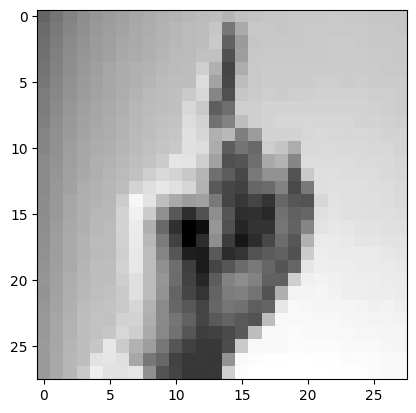

In [14]:
image = F.to_pil_image(x_0)
plt.imshow(image, cmap='gray')

##### RandomResizeCrop

This transform will randomly resize the input image based on `scale`, and then [crop](https://en.wikipedia.org/wiki/Cropping_(image)) it to a size we specify. 

In this case, crop it to the original image dimensions. To do this, TorchVision needs to know the [aspect ratio](https://en.wikipedia.org/wiki/Aspect_ratio_(image)) of the image it is scaling. Since height is the same as width, aspect `ratio` is 1:1.

In [15]:
trans = transforms.Compose([
    transforms.RandomResizedCrop((IMG_WIDTH, IMG_HEIGHT), scale=(.7, 1), ratio=(1, 1)),
])

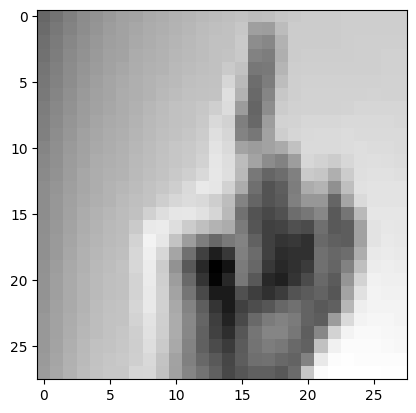

In [19]:
# should be different each time it is run
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')

In [17]:
new_x_0.shape

torch.Size([1, 28, 28])

##### RandomHorizontalFlip

Can also randomly flip images [Horizontally](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.RandomHorizontalFlip) or [Vertically](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.RandomVerticalFlip). 

However, for these images, only flip them horizontally.
Why? Because the American Sign Language can be done with either the left or right hand being dominant. However, it is unlikely to see sign language from upside down

In [20]:
trans = transforms.Compose([
    transforms.RandomHorizontalFlip()
])

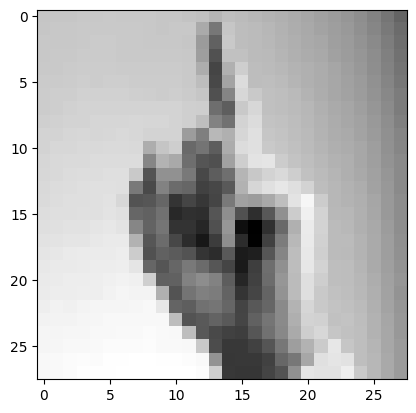

In [22]:
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')

##### RandomRotation

Can also randomly rotate the image to add more variability. Just like with with other augmentation techniques, it's easy to accidentally go too far. 

With ASL, if rotated too much, `D`s might look like `G`s and vice-versa. Because of this, limit it to `30` degrees.

In [23]:
trans = transforms.Compose([
    transforms.RandomRotation(10)
])

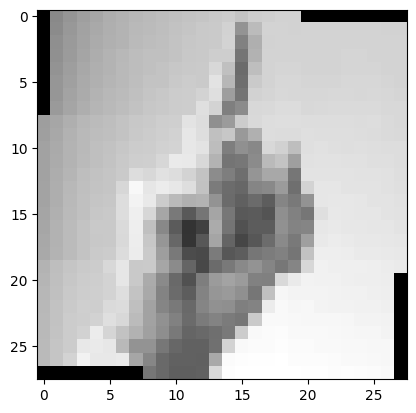

In [25]:
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')

##### ColorJitter

The `ColorJitter` transform has 4 arguments:
* [brightness](https://en.wikipedia.org/wiki/Brightness)
* [contrast](https://en.wikipedia.org/wiki/Contrast_(vision))
* [saturation](https://en.wikipedia.org/wiki/Colorfulness#Saturation)
* [hue](https://en.wikipedia.org/wiki/Hue)


The latter 2 apply to color images, so only use the first 2 for now.

In [26]:
brightness = .2  # Change to be from 0 to 1
contrast = .5  # Change to be from 0 to 1

trans = transforms.Compose([
    transforms.ColorJitter(brightness=brightness, contrast=contrast)
])

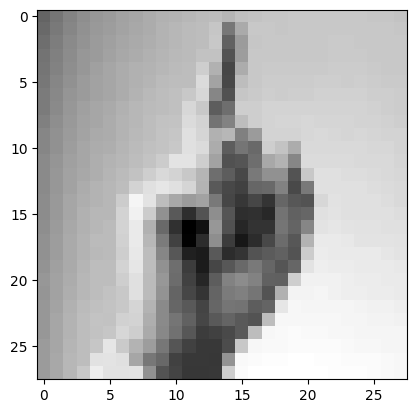

In [27]:
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')

##### Compose

Create a sequence of these random transformations with `Compose`.

In [28]:
random_transforms = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomResizedCrop((IMG_WIDTH, IMG_HEIGHT), scale=(.9, 1), ratio=(1, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=.2, contrast=.5)
])

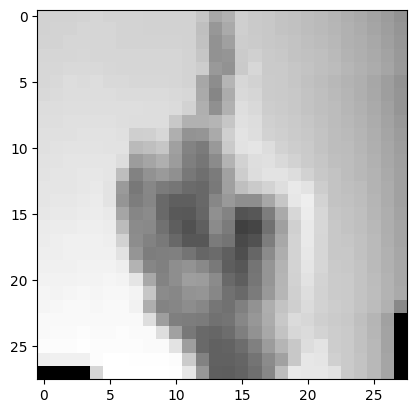

In [29]:
new_x_0 = random_transforms(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')

#### Training with Augmentation

The training is mostly the same, but there is one line of change. Before passing images to the model, apply `random_transforms`. 

For conveneince,`get_batch_accuracy` is moved to a [utils](./utils.py) file.

In [30]:
def train():
    loss = 0
    accuracy = 0

    model.train()
    for x, y in train_loader:
        output = model(random_transforms(x))  # Updated
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += utils.get_batch_accuracy(output, y, train_N)
    print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

On the other hamd, validation remains the same. There are no random transformations.

In [31]:
def validate():
    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            output = model(x)

            loss += loss_function(output, y).item()
            accuracy += utils.get_batch_accuracy(output, y, valid_N)
    print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

##### Training Loop

In [32]:
epochs = 20

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train()
    validate()

Epoch: 0
Train - Loss: 2769.9491 Accuracy: 0.0473
Valid - Loss: 724.0720 Accuracy: 0.0508
Epoch: 1
Train - Loss: 2770.4077 Accuracy: 0.0473
Valid - Loss: 723.7280 Accuracy: 0.0484
Epoch: 2
Train - Loss: 2769.5888 Accuracy: 0.0464
Valid - Loss: 724.2452 Accuracy: 0.0523
Epoch: 3
Train - Loss: 2767.9558 Accuracy: 0.0455
Valid - Loss: 723.8453 Accuracy: 0.0508
Epoch: 4
Train - Loss: 2767.7777 Accuracy: 0.0471
Valid - Loss: 724.4495 Accuracy: 0.0496
Epoch: 5
Train - Loss: 2769.1781 Accuracy: 0.0467
Valid - Loss: 723.3788 Accuracy: 0.0478
Epoch: 6
Train - Loss: 2769.6506 Accuracy: 0.0441
Valid - Loss: 723.9980 Accuracy: 0.0485
Epoch: 7
Train - Loss: 2768.8182 Accuracy: 0.0445
Valid - Loss: 722.8556 Accuracy: 0.0517
Epoch: 8
Train - Loss: 2768.6436 Accuracy: 0.0476
Valid - Loss: 724.0357 Accuracy: 0.0488
Epoch: 9
Train - Loss: 2769.2502 Accuracy: 0.0469
Valid - Loss: 722.2472 Accuracy: 0.0506
Epoch: 10
Train - Loss: 2770.3109 Accuracy: 0.0469
Valid - Loss: 723.6230 Accuracy: 0.0524
Epoch: 11

#### Conclusion
Notice that the validation accuracy is higher, and more consistent. This means that the model is no longer overfitting in the way it was; it generalizes better, making better predictions on new data.

The training accuracy may be lower, and that's ok. Compared to before, the model is being exposed to a much larger variety of data.

#### Save the Model
Now that a well-trained model is obtained, it can be deployed to perform inference on new images.

To save the model to disk, PyTorch has [multiple ways](https://pytorch.org/tutorials/beginner/saving_loading_models.html), but for now, use `torch.save`. 

Also save the code for `MyConvBlock` custom module, which in [utils.py](./utils.py). 

In the next notebook, load the model and use it to read new sign language pictures.

PyTorch cannot save a compiled model ([see this post](https://discuss.pytorch.org/t/how-to-save-load-a-model-with-torch-compile/179739)), so instead 

In [35]:
torch.save(base_model, './Models/asl_model.pth')

print("Model saved successfully")

Model saved successfully
